#XGBoost
XGBoost (Extreme Gradient Boosting) is a powerful and scalable machine learning algorithm based on gradient boosting decision trees. Known for its high performance, speed, and ability to handle structured data, XGBoost has become a go-to choice for many data science tasks, including classification, regression, and ranking problems. It excels in dealing with tabular data, offers robust regularization techniques to prevent overfitting, and supports parallel processing for faster training.

In this notebook, we apply XGBoost to classify images into two categories: Human and AI. By extracting features from images using techniques like Local Binary Pattern (LBP), we prepare the data for training the model. Through hyperparameter tuning with Grid Search, we optimize the performance of the classifier and evaluate it using standard metrics such as accuracy, precision, recall and F1-score.

### Loading Dataset from Kaggle
In this subsection, we will load the dataset from Kaggle. The dataset is already organized into separate train and test folders.

We will also read and store the paths to these images for further preprocessing and usage.


In [ ]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

100%|██████████| 9.76G/9.76G [07:33<00:00, 23.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4


## Data Preprocessing
In this subsection, we will preprocess the image data to prepare it for training with the XGBoost model.

First, we will load the necessary libraries and read the CSV files that contain the labels for the images. These labels indicate whether each image is real or AI-generated, which will be used as the target variable for training.

In [ ]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import seaborn as sns
import time
import random
from skimage.transform import resize
from skimage.io import imread
import matplotlib.pyplot as plt
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from skimage.feature import hog
from skimage.feature import local_binary_pattern

In [ ]:
TRAIN_CSV = path + '/train.csv'
TEST_CSV = path + '/test.csv'
DATA_DIR = path

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python's random module

set_seed()

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
train_df = train_df[['file_name','label']]
train_df.columns = ['id','label']

In [ ]:
test_df = pd.read_csv(TEST_CSV)
test_df.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


### Feature Extraction with Local Binary Patterns (LBP)
In this part, we extract texture-based features from each image using Local Binary Patterns (LBP), a widely used method in image analysis for capturing local texture information.

We define a function `extract_lbp_features` that performs the following steps:


1.   Loads the image in grayscale mode.
2.   Resizes it to a fixed size (64×64) for consistency.
3.   Applies Gaussian blur to reduce noise.
4.   Computes the LBP of the image using a defined radius and number of points.
5.   Generates a normalized histogram of LBP values, which serves as the feature vector.
This histogram encodes the texture structure of the image and is later used as input to the XGBoost model for classification.

This histogram encodes the texture structure of the image and is later used as input to the XGBoost model for classification.


In [ ]:
def extract_lbp_features(img_path, radius=3, points=24,method="uniform"):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh xám

    if img is None:
        print(f"Error loading image: {img_path}")
        return np.zeros(points + 2)  # Tránh lỗi khi ảnh không load được

    img = cv2.resize(img, (64, 64))  # Resize ảnh về kích thước cố định
    img = cv2.GaussianBlur(img, (5, 5), 0)
    lbp = local_binary_pattern(img, points, radius, method)  # Áp dụng LBP

    # Tính histogram của các giá trị LBP
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Chuẩn hóa histogram tránh lỗi chia cho 0
    return hist


Once the function is defined, we apply it to all training images to extract the features `X` and corresponding labels `y`

In [ ]:
X = np.array([extract_lbp_features(os.path.join(path,img_path)) for img_path in train_df['id']])
y = np.array(train_df['label'])

### Splitting the Dataset
After extracting features from the images, we divide the dataset into training and testing subsets to evaluate the model's performance on unseen data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Hyperparameter Grid Definition
To optimize the performance of the XGBoost model, we define a set of hyperparameters to explore during training. These hyperparameters control how the model learns and can significantly impact accuracy, overfitting, and training time.

We prepare a `param_grid` dictionary that specifies a range of values for several key parameters:


*   `n_estimators`: The number of trees in the model.
*   `max_depth`: The maximum depth of each decision tree, controlling model complexity.
*   `learning_rate`: The step size shrinkage used to prevent overfitting.
*   `gamma`: The minimum loss reduction required to make a further partition on a leaf node.
* `subsample`: The fraction of samples to be used for each tree, helping to reduce overfitting.

This grid will later be used in a grid search to find the best combination of parameters.

In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
}

## Model Training with Hyperparameter Tuning
We initialize the `XGBClassifier` with several important settings:


*   `tree_method='gpu_hist'`: Uses the GPU for faster training with the histogram-based algorithm.
*   `predictor='gpu_predictor'`: Ensures that prediction is also done on the GPU.
*  `use_label_encoder=False`: Disables the use of the label encoder (no longer needed in newer versions of XGBoost).
*  `eval_metric='logloss'`: Specifies the evaluation metric as log loss, which is commonly used for classification tasks.


In [ ]:
xgb_clf = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    use_label_encoder=False,
    eval_metric='logloss'
    )

We then pass this classifier to the `GridSearchCV` with the following parameters:

* `param_grid`: The hyperparameter grid to search over.

* `cv=5`: A 5-fold cross-validation to evaluate the performance.

* `scoring='accuracy'`: The scoring metric to optimize (accuracy in this case).

* `n_jobs=-1`: Use all available CPU cores to speed up the grid search.

* `verbose=3`: Outputs detailed progress during the grid search.

This process will train multiple models with different hyperparameter combinations, using cross-validation to determine which combination results in the best model performance.

In [ ]:
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:36:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:36:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     predictor='gpu_predictor', ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 300, 500],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=3)

## Model Evaluation


In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
Best score: 0.7214196372732957


The best score achieved during the grid search is 0.7214, indicating that the model has achieved an accuracy of approximately 72.14% during cross-validation.

After identifying the best hyperparameters from the grid search, we can evaluate the performance of the optimized XGBoost model on the test set. This will give us a more accurate picture of how well the model generalizes to unseen data.

We first extract the best model from the grid search and use it to make predictions on the test set `X_test`.

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:36:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:36:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import sklearn.metrics as metrics

The `classification_report` will give us detailed performance metrics for each class ('Human' and 'AI'). We can interpret these metrics to assess whether the model is biased towards one class or has difficulty distinguishing between them.

In [ ]:
print(classification_report(y_test, y_pred, target_names=['Human', 'AI']))

              precision    recall  f1-score   support

       Human       0.72      0.72      0.72      7995
          AI       0.72      0.72      0.72      7995

    accuracy                           0.72     15990
   macro avg       0.72      0.72      0.72     15990
weighted avg       0.72      0.72      0.72     15990



The classification report shows that the model has an accuracy of 72% and performs equally well for both classes (Human and AI) with a precision, recall, and F1-score of 0.72 for each. This indicates balanced performance, with the model correctly predicting 72% of both human and AI-generated images. While this is a decent result, there is room for improvement, and further tuning or feature engineering could enhance its performance.

### Confusion Matrix
To gain a deeper insight into how well the model is distinguishing between the Human and AI classes, we plot the confusion matrix.

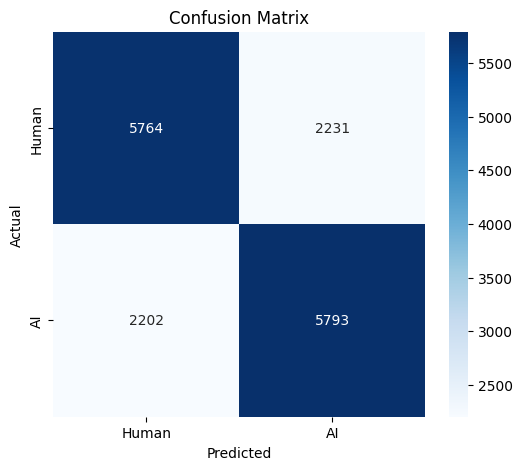

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Accuracy can be calculated as (TP + TN) / Total = (5793 + 5764) / (5764 + 2231 + 2202 + 5793) ≈ 72.3%.

The model has a relatively balanced performance, but there’s room for improvement, as the FP and FN counts are significant.

### Receiver Operating Characteristic (ROC) Curve
The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various thresholds.



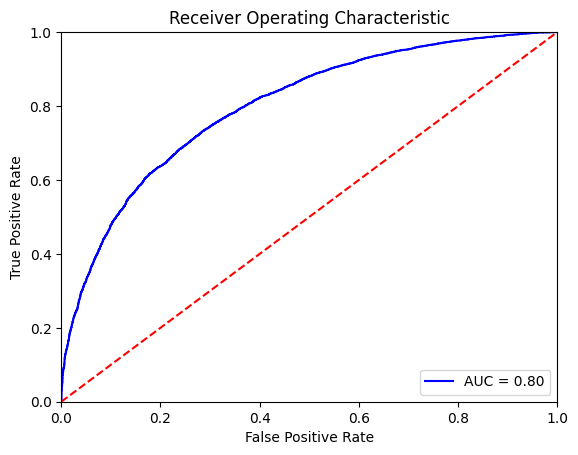

In [ ]:
preds = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The Area Under the Curve (AUC) is 0.80, indicating good model performance (an AUC of 0.5 represents a random classifier, while 1.0 is perfect). The curve is well above the red dashed line (random classifier), suggesting the model effectively discriminates between classes.

### Saving the Trained Model
Finally, we will save the trained XGBoost model to a file using Joblib. Saving the model allows us to persist the model's state, so it can be loaded later for inference or further evaluation, without the need to retrain the model.

In [ ]:
import joblib

# save
joblib.dump(best_model,"xgboost_final.pkl")

['/content/drive/My Drive/xgboost_final.pkl']

This stores the complete model (including structure and weights) in the `xgboost_final.pkl` file, located in the `/content/` directory (Google Colab).

To use the model for later evaluation or inference, you should manually download this file.